# Cross Validation

Este notebook implementa técnicas de validación cruzada para evaluar modelos de machine learning.

## Características:
- K-Fold Cross Validation
- Stratified K-Fold para problemas de clasificación
- Time Series Split para datos temporales
- Grid Search con Cross Validation
- Comparación de métricas entre diferentes folds
- Visualización de resultados de validación cruzada


In [1]:
# Imports y configuración
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    cross_val_score, KFold, StratifiedKFold, TimeSeriesSplit,
    GridSearchCV, cross_validate, validation_curve
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, make_scorer
)
import warnings
warnings.filterwarnings('ignore')

# Configuración general de gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# Configuración del dataset
DATA_PATH = Path(r"C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Data\Global_Cybersecurity_Threats_2015-2024.csv")

# Cargar datos
df = pd.read_csv(DATA_PATH)
print("Shape del dataset:", df.shape)
print("Columnas:", list(df.columns))
df.head()


Shape del dataset: (3000, 10)
Columnas: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)']


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [3]:
# Preparación de datos para clasificación
print("=== PREPARACIÓN DE DATOS PARA CLASIFICACIÓN ===")

# Para clasificación: Attack Type como objetivo
y_class = df['Attack Type']
X_class = df.drop(columns=['Attack Type'])

# Mapear etiquetas no numéricas a códigos
if not pd.api.types.is_numeric_dtype(y_class):
    y_class = y_class.astype('category').cat.codes
    print(f"Mapeo de etiquetas a códigos aplicado sobre 'Attack Type'.")

# One-hot encoding para columnas categóricas en X
X_class = pd.get_dummies(X_class, drop_first=True)

print("Shape X_class:", X_class.shape, "- y_class:", y_class.shape)
print("Clases en y_class y conteo:")
print(y_class.value_counts())

# Escalado para clasificación
scaler_class = StandardScaler()
X_class_scaled = scaler_class.fit_transform(X_class)


=== PREPARACIÓN DE DATOS PARA CLASIFICACIÓN ===
Mapeo de etiquetas a códigos aplicado sobre 'Attack Type'.
Shape X_class: (3000, 29) - y_class: (3000,)
Clases en y_class y conteo:
0    531
3    529
5    503
4    493
1    485
2    459
Name: count, dtype: int64


In [4]:
# Preparación de datos para regresión
print("\n=== PREPARACIÓN DE DATOS PARA REGRESIÓN ===")

# Para regresión: Financial Loss como objetivo
y_reg = df['Financial Loss (in Million $)']
X_reg = df[['Number of Affected Users', 'Year']]  # Variables numéricas simples

print("Shape X_reg:", X_reg.shape, "- y_reg:", y_reg.shape)
print("Estadísticas de y_reg:")
print(y_reg.describe())

# Escalado para regresión
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)



=== PREPARACIÓN DE DATOS PARA REGRESIÓN ===
Shape X_reg: (3000, 2) - y_reg: (3000,)
Estadísticas de y_reg:
count    3000.000000
mean       50.492970
std        28.791415
min         0.500000
25%        25.757500
50%        50.795000
75%        75.630000
max        99.990000
Name: Financial Loss (in Million $), dtype: float64


In [5]:
# 1. K-Fold Cross Validation para Clasificación
print("=== K-FOLD CROSS VALIDATION PARA CLASIFICACIÓN ===")

# Crear el modelo
log_reg = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluar con diferentes métricas
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
cv_results = cross_validate(log_reg, X_class_scaled, y_class, 
                           cv=kfold, scoring=scoring, return_train_score=True)

print("Resultados K-Fold (5 folds):")
for metric in scoring:
    test_scores = cv_results[f'test_{metric}']
    train_scores = cv_results[f'train_{metric}']
    print(f"{metric}:")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print()


=== K-FOLD CROSS VALIDATION PARA CLASIFICACIÓN ===
Resultados K-Fold (5 folds):
accuracy:
  Test:  0.1733 (+/- 0.0373)
  Train: 0.2355 (+/- 0.0067)

precision_weighted:
  Test:  0.1725 (+/- 0.0403)
  Train: 0.2336 (+/- 0.0105)

recall_weighted:
  Test:  0.1733 (+/- 0.0373)
  Train: 0.2355 (+/- 0.0067)

f1_weighted:
  Test:  0.1673 (+/- 0.0388)
  Train: 0.2286 (+/- 0.0080)



In [6]:
# 2. Stratified K-Fold para Clasificación
print("=== STRATIFIED K-FOLD PARA CLASIFICACIÓN ===")

# Stratified K-Fold mantiene la proporción de clases en cada fold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results_stratified = cross_validate(log_reg, X_class_scaled, y_class, 
                                      cv=stratified_kfold, scoring=scoring, 
                                      return_train_score=True)

print("Resultados Stratified K-Fold (5 folds):")
for metric in scoring:
    test_scores = cv_results_stratified[f'test_{metric}']
    train_scores = cv_results_stratified[f'train_{metric}']
    print(f"{metric}:")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print()

# Comparar con K-Fold normal
print("Comparación K-Fold vs Stratified K-Fold:")
print("Accuracy Test Scores:")
print(f"  K-Fold:        {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
print(f"  Stratified:    {cv_results_stratified['test_accuracy'].mean():.4f} (+/- {cv_results_stratified['test_accuracy'].std() * 2:.4f})")


=== STRATIFIED K-FOLD PARA CLASIFICACIÓN ===
Resultados Stratified K-Fold (5 folds):
accuracy:
  Test:  0.1810 (+/- 0.0232)
  Train: 0.2317 (+/- 0.0123)

precision_weighted:
  Test:  0.1777 (+/- 0.0233)
  Train: 0.2313 (+/- 0.0120)

recall_weighted:
  Test:  0.1810 (+/- 0.0232)
  Train: 0.2317 (+/- 0.0123)

f1_weighted:
  Test:  0.1743 (+/- 0.0225)
  Train: 0.2254 (+/- 0.0130)

Comparación K-Fold vs Stratified K-Fold:
Accuracy Test Scores:
  K-Fold:        0.1733 (+/- 0.0373)
  Stratified:    0.1810 (+/- 0.0232)


In [7]:
# 3. Cross Validation para Regresión
print("=== CROSS VALIDATION PARA REGRESIÓN ===")

# Crear el modelo de regresión
lin_reg = LinearRegression()

# K-Fold para regresión
kfold_reg = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Métricas para regresión
scoring_reg = ['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2']

cv_results_reg = cross_validate(lin_reg, X_reg_scaled, y_reg, 
                               cv=kfold_reg, scoring=scoring_reg, 
                               return_train_score=True)

print("Resultados K-Fold para Regresión (5 folds):")
for metric in scoring_reg:
    test_scores = cv_results_reg[f'test_{metric}']
    train_scores = cv_results_reg[f'train_{metric}']
    
    # Convertir MSE y MAE a valores positivos para interpretación
    if 'neg_' in metric:
        test_scores = -test_scores
        train_scores = -train_scores
        metric_name = metric.replace('neg_', '')
    else:
        metric_name = metric
    
    print(f"{metric_name}:")
    print(f"  Test:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
    print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
    print()


=== CROSS VALIDATION PARA REGRESIÓN ===
Resultados K-Fold para Regresión (5 folds):
mean_squared_error:
  Test:  830.5533 (+/- 29.4913)
  Train: 828.3538 (+/- 7.4170)

mean_absolute_error:
  Test:  24.9985 (+/- 0.6879)
  Train: 24.9585 (+/- 0.1817)

r2:
  Test:  -0.0033 (+/- 0.0043)
  Train: 0.0003 (+/- 0.0003)



In [8]:
# 4. Time Series Split (para datos temporales)
print("=== TIME SERIES SPLIT ===")

# Ordenar datos por año para simular serie temporal
df_sorted = df.sort_values('Year').reset_index(drop=True)
X_ts = df_sorted[['Number of Affected Users']].values
y_ts = df_sorted['Financial Loss (in Million $)'].values

# Time Series Split
ts_split = TimeSeriesSplit(n_splits=3)

print("Time Series Split (3 folds):")
for fold, (train_idx, test_idx) in enumerate(ts_split.split(X_ts)):
    X_train_ts, X_test_ts = X_ts[train_idx], X_ts[test_idx]
    y_train_ts, y_test_ts = y_ts[train_idx], y_ts[test_idx]
    
    # Entrenar modelo
    model_ts = LinearRegression()
    model_ts.fit(X_train_ts, y_train_ts)
    
    # Predecir y evaluar
    y_pred_ts = model_ts.predict(X_test_ts)
    mse = mean_squared_error(y_test_ts, y_pred_ts)
    r2 = r2_score(y_test_ts, y_pred_ts)
    
    print(f"Fold {fold + 1}:")
    print(f"  Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    print(f"  MSE: {mse:.4f}, R²: {r2:.4f}")
    print()


=== TIME SERIES SPLIT ===
Time Series Split (3 folds):
Fold 1:
  Train size: 750, Test size: 750
  MSE: 851.7292, R²: 0.0006

Fold 2:
  Train size: 1500, Test size: 750
  MSE: 802.4049, R²: -0.0074

Fold 3:
  Train size: 2250, Test size: 750
  MSE: 819.5626, R²: -0.0015



In [9]:
# 5. Grid Search con Cross Validation
print("=== GRID SEARCH CON CROSS VALIDATION ===")

# Definir parámetros para búsqueda
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 500]
}

# Crear GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

# Ejecutar búsqueda
grid_search.fit(X_class_scaled, y_class)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)
print()

# Mostrar resultados de todos los parámetros
results_df = pd.DataFrame(grid_search.cv_results_)
print("Resultados de Grid Search:")
print(results_df[['param_C', 'param_max_iter', 'mean_test_score', 'std_test_score']].head(10))


=== GRID SEARCH CON CROSS VALIDATION ===
Mejores parámetros: {'C': 10, 'max_iter': 100}
Mejor score: 0.174

Resultados de Grid Search:
   param_C  param_max_iter  mean_test_score  std_test_score
0      0.1             100         0.171333        0.007775
1      0.1             200         0.171333        0.007775
2      0.1             500         0.171333        0.007775
3      1.0             100         0.173000        0.008327
4      1.0             200         0.173000        0.008327
5      1.0             500         0.173000        0.008327
6     10.0             100         0.174000        0.008602
7     10.0             200         0.174000        0.008602
8     10.0             500         0.174000        0.008602
9    100.0             100         0.174000        0.008602


=== VALIDATION CURVE ===


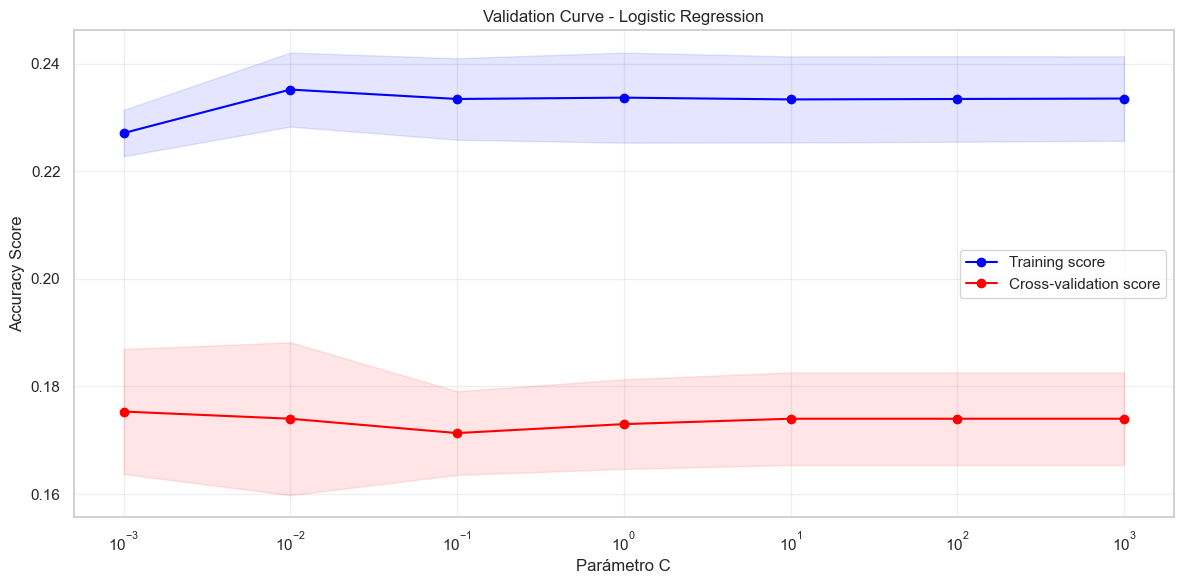

Validation Curve completada. El gráfico muestra cómo varía el rendimiento con diferentes valores del parámetro C.


In [10]:
# 6. Validation Curve
print("=== VALIDATION CURVE ===")

# Crear validation curve para el parámetro C de LogisticRegression
param_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_scores, test_scores = validation_curve(
    LogisticRegression(random_state=RANDOM_STATE),
    X_class_scaled, y_class,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calcular media y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Visualizar validation curve
plt.figure(figsize=(12, 6))
plt.semilogx(param_range, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.semilogx(param_range, test_mean, 'o-', color='red', label='Cross-validation score')
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')

plt.xlabel('Parámetro C')
plt.ylabel('Accuracy Score')
plt.title('Validation Curve - Logistic Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Validation Curve completada. El gráfico muestra cómo varía el rendimiento con diferentes valores del parámetro C.")


=== COMPARACIÓN DE MODELOS CON CROSS VALIDATION ===
Logistic Regression: 0.1730 (+/- 0.0167)
KNN (k=3): 0.1660 (+/- 0.0203)
KNN (k=5): 0.1723 (+/- 0.0260)
KNN (k=7): 0.1637 (+/- 0.0265)


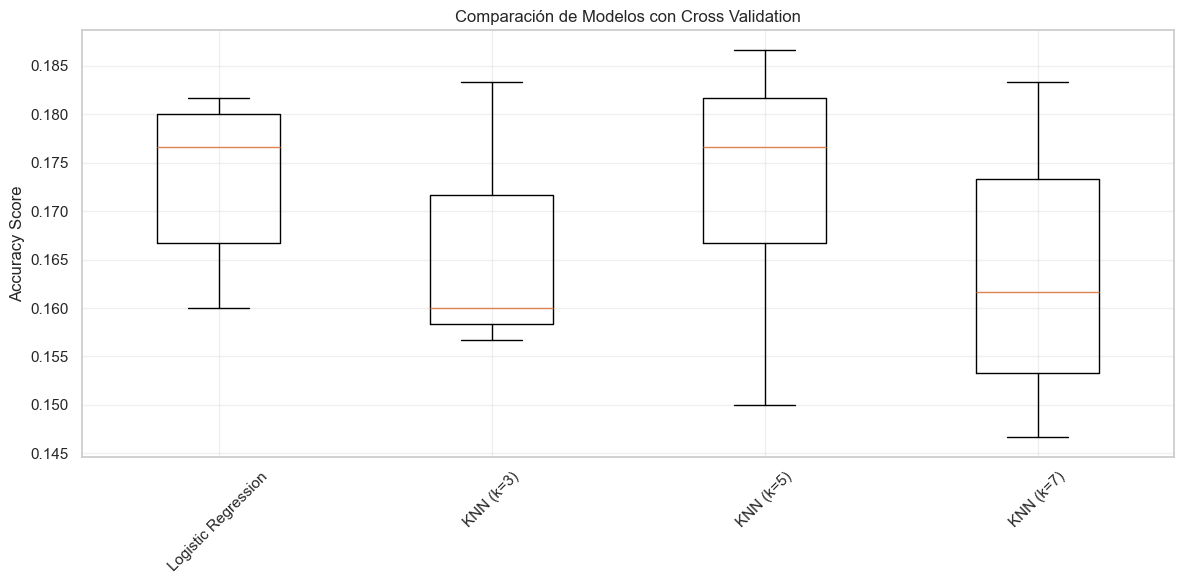


Mejor modelo: Logistic Regression con accuracy promedio de 0.1730


In [11]:
# 7. Comparación de Modelos con Cross Validation
print("=== COMPARACIÓN DE MODELOS CON CROSS VALIDATION ===")

# Definir modelos para comparar
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'KNN (k=7)': KNeighborsClassifier(n_neighbors=7)
}

# Evaluar cada modelo
results_comparison = {}

for name, model in models.items():
    scores = cross_val_score(model, X_class_scaled, y_class, cv=5, scoring='accuracy')
    results_comparison[name] = scores
    print(f"{name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Visualizar comparación
plt.figure(figsize=(12, 6))
model_names = list(results_comparison.keys())
model_scores = [results_comparison[name] for name in model_names]

plt.boxplot(model_scores, labels=model_names)
plt.ylabel('Accuracy Score')
plt.title('Comparación de Modelos con Cross Validation')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Encontrar el mejor modelo
best_model = max(results_comparison.items(), key=lambda x: x[1].mean())
print(f"\nMejor modelo: {best_model[0]} con accuracy promedio de {best_model[1].mean():.4f}")


=== ANÁLISIS DE VARIANZA EN CROSS VALIDATION ===
3-Fold CV: Mean=0.1677, Std=0.0103
5-Fold CV: Mean=0.1733, Std=0.0186
10-Fold CV: Mean=0.1760, Std=0.0204


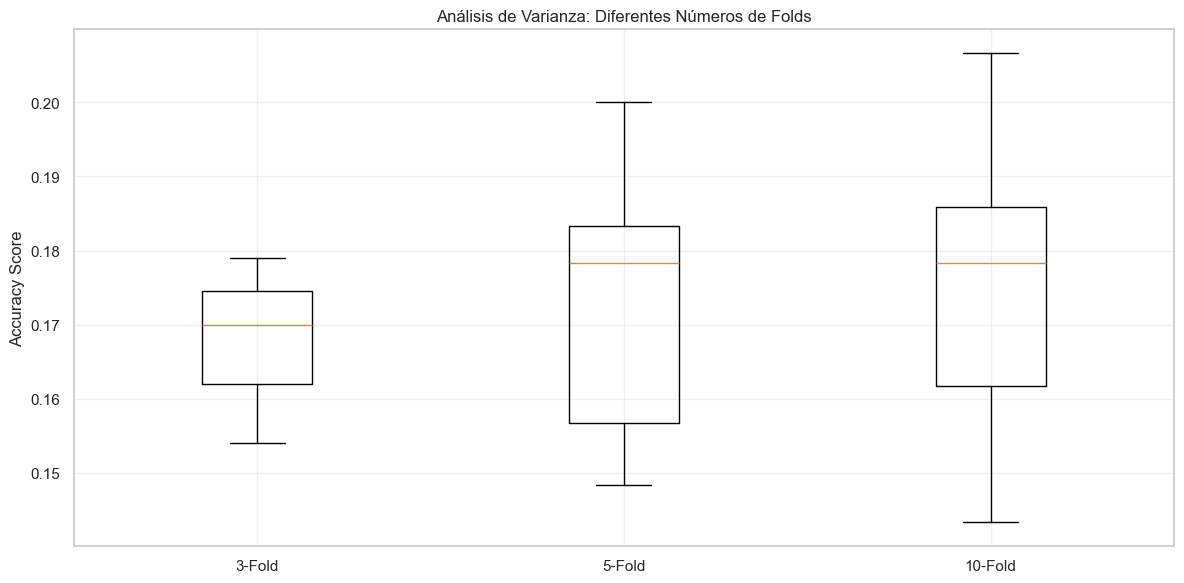


Observaciones:
- Más folds generalmente reducen la varianza pero aumentan el tiempo de cómputo
- 5-fold es un buen balance entre estabilidad y eficiencia
- La varianza alta puede indicar que el modelo es inestable o que hay datos problemáticos


In [12]:
# 8. Análisis de Varianza en Cross Validation
print("=== ANÁLISIS DE VARIANZA EN CROSS VALIDATION ===")

# Analizar la varianza entre folds para diferentes números de folds
fold_numbers = [3, 5, 10]
variance_analysis = {}

for n_folds in fold_numbers:
    kfold_var = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(LogisticRegression(max_iter=200, random_state=RANDOM_STATE), 
                            X_class_scaled, y_class, cv=kfold_var, scoring='accuracy')
    variance_analysis[n_folds] = scores
    print(f"{n_folds}-Fold CV: Mean={scores.mean():.4f}, Std={scores.std():.4f}")

# Visualizar análisis de varianza
plt.figure(figsize=(12, 6))
fold_labels = [f'{n}-Fold' for n in fold_numbers]
fold_scores = [variance_analysis[n] for n in fold_numbers]

plt.boxplot(fold_scores, labels=fold_labels)
plt.ylabel('Accuracy Score')
plt.title('Análisis de Varianza: Diferentes Números de Folds')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservaciones:")
print("- Más folds generalmente reducen la varianza pero aumentan el tiempo de cómputo")
print("- 5-fold es un buen balance entre estabilidad y eficiencia")
print("- La varianza alta puede indicar que el modelo es inestable o que hay datos problemáticos")


In [13]:
# 9. Resumen y Recomendaciones
print("=== RESUMEN Y RECOMENDACIONES ===")

print("Técnicas de Cross Validation implementadas:")
print("1. K-Fold Cross Validation: División aleatoria en k folds")
print("2. Stratified K-Fold: Mantiene proporción de clases en cada fold")
print("3. Time Series Split: Para datos temporales (no aleatorio)")
print("4. Grid Search: Búsqueda de hiperparámetros con CV")
print("5. Validation Curve: Análisis de sensibilidad de parámetros")
print("6. Comparación de modelos: Evaluación múltiple con CV")
print("7. Análisis de varianza: Estabilidad con diferentes números de folds")

print("\nRecomendaciones:")
print("- Usar Stratified K-Fold para problemas de clasificación desbalanceados")
print("- Time Series Split para datos con dependencia temporal")
print("- 5-fold CV es generalmente suficiente para la mayoría de casos")
print("- Grid Search es útil para optimizar hiperparámetros")
print("- Validation curves ayudan a detectar overfitting/underfitting")
print("- Comparar múltiples modelos para encontrar el mejor")
print("- La varianza alta en CV puede indicar problemas en los datos o modelo")

print("\nMétricas importantes a considerar:")
print("- Accuracy: Proporción de predicciones correctas")
print("- Precision: Proporción de positivos predichos que son realmente positivos")
print("- Recall: Proporción de positivos reales que fueron predichos correctamente")
print("- F1-Score: Media armónica entre precision y recall")
print("- R²: Coeficiente de determinación para regresión")
print("- MSE/MAE: Errores cuadráticos/absolutos medios para regresión")


=== RESUMEN Y RECOMENDACIONES ===
Técnicas de Cross Validation implementadas:
1. K-Fold Cross Validation: División aleatoria en k folds
2. Stratified K-Fold: Mantiene proporción de clases en cada fold
3. Time Series Split: Para datos temporales (no aleatorio)
4. Grid Search: Búsqueda de hiperparámetros con CV
5. Validation Curve: Análisis de sensibilidad de parámetros
6. Comparación de modelos: Evaluación múltiple con CV
7. Análisis de varianza: Estabilidad con diferentes números de folds

Recomendaciones:
- Usar Stratified K-Fold para problemas de clasificación desbalanceados
- Time Series Split para datos con dependencia temporal
- 5-fold CV es generalmente suficiente para la mayoría de casos
- Grid Search es útil para optimizar hiperparámetros
- Validation curves ayudan a detectar overfitting/underfitting
- Comparar múltiples modelos para encontrar el mejor
- La varianza alta en CV puede indicar problemas en los datos o modelo

Métricas importantes a considerar:
- Accuracy: Proporci